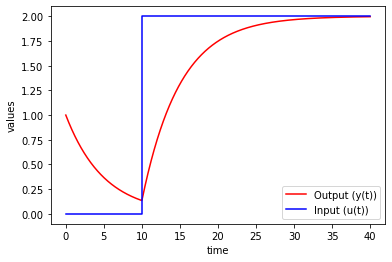

In [1]:
#ejemplo sacado de https://apmonitor.com/pdc/index.php/Main/SolveDifferentialEquations

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# function that returns dy/dt
def model(y,t):
    # u steps from 0 to 2 at t=10
    if t<10.0:
        u = 0
    else:
        u = 2
    dydt = (-y + u)/5.0
    return dydt

# initial condition
y0 = 1

# time points
t = np.linspace(0,40,1000)

# solve ODE
y = odeint(model,y0,t)

# plot results
plt.plot(t,y,'r-',label='Output (y(t))')
plt.plot([0,10,10,40],[0,0,2,2],'b-',label='Input (u(t))')
plt.ylabel('values')
plt.xlabel('time')
plt.legend(loc='best')
plt.show()

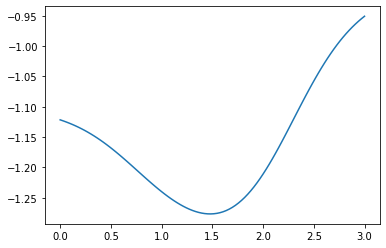

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#w_i = [-1,  -1,  -1.1,  -1,  -1.1,  -1.2,  -1.4,  -0.9]
w_i = [-1.1,  -1.3,  -1.4,  -0.9]

#z_i = np.linspace(0.0,3.0,9)
z_i = np.linspace(0.0,3.0,5)

z=np.linspace(0.0,3,100)

def wz_de(z):
    def bines(w_2,w_1,z_2,z_1,eta):
        return (w_2-w_1)*(1+np.tanh((z_2-z_1)/eta))/2
    w=w_i[0]
    for jj in range(len(w_i)-1):
        w+=bines(w_i[jj+1],w_i[jj],z,z_i[jj+1],0.7)
    return(w)

plt.plot(z,wz_de(z))

[0.7        0.68478082 0.6702819  0.65637478 0.64295143 0.62992103
 0.61720795 0.60475034 0.59249918 0.58041752 0.56847984 0.55667127
 0.54498666 0.53342938 0.52200998 0.51074468 0.49965384 0.48876049
 0.47808914 0.46766476 0.45751216 0.4476555  0.43811823 0.42892297
 0.42009164 0.41164543 0.40360481 0.39598934 0.38881745 0.38210593
 0.37586953 0.37012031 0.36486697 0.36011433 0.35586272 0.35210762
 0.34883938 0.34604326 0.34369969 0.34178478 0.34027103 0.33912825
 0.33832447 0.33782698 0.33760319 0.33762143 0.33785158 0.33826552
 0.33883747 0.33954407]


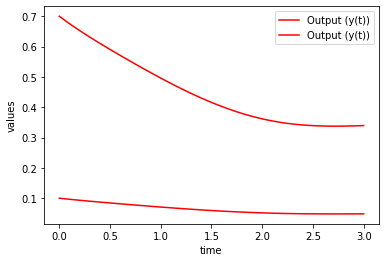

In [4]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# function that returns drho/dz
def model(rho,z):
    drhodz = 3*((1+wz_de(z))/(1+z))*rho
    return drhodz

# initial condition
y0 = [0.7,0.1]

# time points
z = np.linspace(0,3,50)

# solve ODE
rho = odeint(model,y0,z)
print(rho[:,0])

# plot results
plt.plot(z,rho,'r-',label='Output (y(t))')
plt.ylabel('values')
plt.xlabel('time')
plt.legend(loc='best')
plt.show()

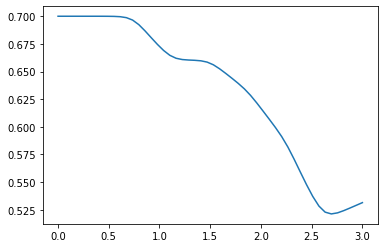

In [12]:
from scipy.interpolate import interp1d
f = interp1d(z,np.reshape(rho,[50]))
plt.plot(z,f(z))

In [6]:
len(z)

50

In [ ]:
#en simpleMC

import math as N
import numpy as np
from simplemc.models.LCDMCosmology import LCDMCosmology
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from simplemc.cosmo.Parameter import Parameter

class IDECosmology(LCDMCosmology):
    def __init__(self):

        self.Nbins_eos = 4
        mean_eos = -1
        self.params = [Parameter("zbin_eos%d"%i, mean_eos, 0.2, (-3.5, 0), "zbin_eos%d"%i) for i in range(self.Nbins_eos)]
        self.pvals = [i.value for i in self.params]
        self.z_i = np.linspace(0.0, 3.0, self.Nbins_eos)


        self.Nbins_ide = 4
        mean_ide = 0
        self.params_ide = [Parameter("zbin_ide%d"%i, mean_ide, -1.0, (-10.0, 0.), "zbin_ide%d"%i) for i in range(self.Nbins_ide)]
        self.pvals_ide = [i.value for i in self.params_ide]
        self.z_i_ide = np.linspace(0.0, 3.0, self.Nbins_ide)


        self.zinter = np.linspace(0.0, 3.0, 50)

        LCDMCosmology.__init__(self, mnu=0)
        self.updateParams([])


    # my free parameters. We add Ok on top of LCDM ones (we inherit LCDM)
    def freeParameters(self):
        l = LCDMCosmology.freeParameters(self)
        l+= self.params
        l+= self.params_ide
        return l

    def updateParams(self, pars):
        ok = LCDMCosmology.updateParams(self, pars)
        if not ok:
            return False
        for p in pars:
            for i in range(self.Nbins_eos):
                if p.name == ("zbin_eos"+str(i)):
                    self.pvals[i] = p.value
            for i in range(self.Nbins_ide):
                if p.name == ("zbin_ide"+str(i)):
                    self.pvals_ide[i] = p.value


        self.initialize()
        return True


    def bines(self, w_2, w_1, z_2, z_1, eta):
        return (w_2-w_1)*(1.0+np.tanh((z_2-z_1)/eta))/2.0

    def de_eos(self, z):
        w = self.pvals[0]
        for jj in range(self.Nbins_eos - 1):
            w+=self.bines(self.pvals[jj+1], self.pvals[jj], z, self.z_i[jj+1], eta=0.15)
        return w

    def de_ide(self, z):
        ide = self.pvals_ide[0]
        for jj in range(self.Nbins_ide - 1):
            ide+=self.bines(self.pvals_ide[jj+1], self.pvals_ide[jj], z, self.z_i_ide[jj+1], eta=0.15)
        return ide

    def de_rhow(self, rho_de, z):
        drhodedz = (3.0/(1.0+z))*((1.0+self.de_eos(z))*rho_de+self.de_ide(z))
        return drhodedz

    def dm_rhow(self, rho_dm, z):
        drhodmdz = (3.0/(1.0+z))*(rho_dm-self.de_ide(z))
        return drhodmdz

    def initialize(self):
        rhowde = np.reshape(odeint(self.de_rhow ,1.0-self.Om ,self.zinter),len(self.zinter))
        rhowdm = np.reshape(odeint(self.dm_rhow ,self.Om ,self.zinter),len(self.zinter))
        self.rhowde_inter = interp1d(self.zinter, rhowde)
        self.rhowdm_inter = interp1d(self.zinter, rhowdm)
        return True

    ## this is relative hsquared as a function of a
    ## i.e. H(z)^2/H(z=0)^2
    def RHSquared_a(self,a):
        z= 1./a - 1
        if z>= 3.0:
            om_de = (1.0-self.Om)
            om_dm = (self.Om)
        else:
            om_de = self.rhowde_inter(z)
            om_dm = self.rhowdm_inter(z)
        return om_dm + self.Omrad/a**4 + om_de



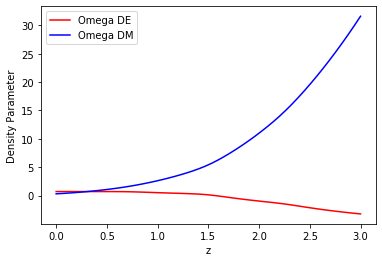

In [12]:
#con tanh
#prueba para ver como varia rho
'''zbin_eos0: -0.9698 +/- 0.0579
zbin_eos1: -1.5549 +/- 0.7411
zbin_eos2: -1.7246 +/- 1.0318
zbin_eos3: -1.7864 +/- 1.0068
zbin_ide0: -0.0210 +/- 0.0161
zbin_ide1: -0.1398 +/- 0.1223
zbin_ide2: -2.5682 +/- 2.1757
zbin_ide3: -4.8722 +/- 2.8267
'''


import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C

#w_i = [-1,  -1,  -0.9,  -1.2,  -1,  -1.5,  -1.4,  -1.3]
#z_ide = [0,  0.1,   0.2, 0.4,   0.6,   1.5,   2.0,   3.0]
z=np.linspace(0.0,3,100)

def wz_tanh(z):
    w_i = [ -0.9698, -1.5549,  -1.7246,  -1.7864]
    z_i = np.linspace(0.0,3.0,len(w_i)+1)
    def bines(w_2,w_1,z_2,z_1,eta):
        return (w_2-w_1)*(1+np.tanh((z_2-z_1)/eta))/2
    w=w_i[0]
    for jj in range(len(w_i)-1):
        w+=bines(w_i[jj+1],w_i[jj],z,z_i[jj+1],0.15)
    return(w)

def ide_tanh(z):
    ide_i = [-0.021, -0.1398, -2.5682, -4.8722]
    z_i = np.linspace(0.0,3.0,len(ide_i)+1)
    def bines(w_2,w_1,z_2,z_1,eta):
        return (w_2-w_1)*(1+np.tanh((z_2-z_1)/eta))/2
    ide=ide_i[0]
    for jj in range(len(ide_i)-1):
        ide+=bines(ide_i[jj+1],ide_i[jj],z,z_i[jj+1],0.15)
    return(ide)

   
# function that returns drho/dz
def model_de(rho,z):
    drhodz = (3/(1+z))*((1+wz_tanh(z))*rho+ide_tanh(z))
    return drhodz

def model_dm(rho,z):
    drhodz = (3/(1+z))*(rho-ide_tanh(z))
    return drhodz

# initial condition
y0 = 0.7

# time points
z = np.linspace(0,3.0,50)

# solve ODE
rho_de = odeint(model_de,y0,z)
rho_dm = odeint(model_dm,1-y0,z)

# plot results
plt.plot(z,rho_de,'r-',label='Omega DE')
plt.plot(z,rho_dm,'b-',label='Omega DM')
plt.ylabel('Density Parameter')
plt.xlabel('z')
plt.legend(loc='best')
plt.savefig('figs_ide/density_parameters_ide.pdf')
plt.show()


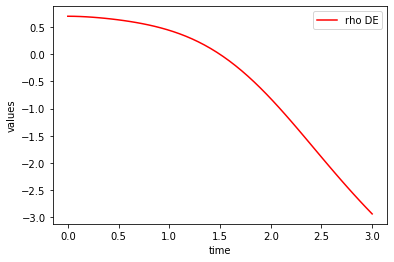

In [10]:
#con procesos gaussianos
#prueba para ver como varia rho
'''zbin_eos0: -0.9698 +/- 0.0579
zbin_eos1: -1.5549 +/- 0.7411
zbin_eos2: -1.7246 +/- 1.0318
zbin_eos3: -1.7864 +/- 1.0068
zbin_ide0: -0.0210 +/- 0.0161
zbin_ide1: -0.1398 +/- 0.1223
zbin_ide2: -2.5682 +/- 2.1757
zbin_ide3: -4.8722 +/- 2.8267
'''


import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C

#w_i = [-1,  -1,  -0.9,  -1.2,  -1,  -1.5,  -1.4,  -1.3]
#z_ide = [0,  0.1,   0.2, 0.4,   0.6,   1.5,   2.0,   3.0]
z=np.linspace(0.0,3,100)

def de_eos(z):
    w_i = [ -0.9698, -1.5549,  -1.7246,  -1.7864]
    z_i = np.atleast_2d(np.linspace(0.0,3.0,len(w_i))).T
    kernel = RBF(1,(1e-2,1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1, optimizer=None)
    gp.fit(z_i, w_i)
    eos = gp.predict([[z]])
    return eos
    
def de_ide(z):
    ide_i = [-0.021, -0.1398, -2.5682, -4.8722]
    z_i = np.atleast_2d(np.linspace(0.0,3.0,len(ide_i))).T
    kernel = RBF(1,(1e-2,1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1, optimizer=None)
    gp.fit(z_i, ide_i)
    ide = gp.predict([[z]])
    return ide
    
# function that returns drho/dz
def model_de(rho,z):
    drhodz = (3/(1+z))*((1+de_eos(z))*rho+de_ide(z))
    return drhodz

def model_dm(rho,z):
    drhodz = (3/(1+z))*(rho-de_ide(z))
    return drhodz

# initial condition
y0 = 0.7

# time points
z = np.linspace(0,3,50)

# solve ODE
rho_de = odeint(model_de,y0,z)
rho_dm = odeint(model_dm,1-y0,z)

# plot results
plt.plot(z,rho_de,'r-',label='rho DE')
#plt.plot(z,rho_dm,'b-',label='rho DM')
plt.ylabel('values')
plt.xlabel('time')
plt.legend(loc='best')
plt.show()


In [13]:
#en simplemc con procesos Gaussianos

import math as N
import numpy as np
from simplemc.models.LCDMCosmology import LCDMCosmology
from scipy.integrate import odeint
from scipy.interpolate import interp1d
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C
from simplemc.cosmo.Parameter import Parameter

class IDEGPCosmology(LCDMCosmology):
    def __init__(self):

        self.Nbins_ide = 4
        mean_ide = 0
        self.params_ide = [Parameter("zbin_ide%d"%i, mean_ide, -1.0, (-10.0, 0.), "zbin_ide%d"%i) for i in range(self.Nbins_ide)]
        self.pvals_ide = [i.value for i in self.params_ide]
        self.z_i_ide = np.linspace(0.0, 3.0, self.Nbins_ide)

        self.zinter = np.linspace(0.0, 3.0, 50)

        LCDMCosmology.__init__(self, mnu=0)
        self.updateParams([])


    # my free parameters. We add Ok on top of LCDM ones (we inherit LCDM)
    def freeParameters(self):
        l = LCDMCosmology.freeParameters(self)
        l+= self.params_ide
        return l

    def updateParams(self, pars):
        ok = LCDMCosmology.updateParams(self, pars)
        if not ok:
            return False
        for p in pars:
            for i in range(self.Nbins_ide):
                if p.name == ("zbin_ide"+str(i)):
                    self.pvals_ide[i] = p.value
        self.initialize()
        return True


    def de_ide(self, z):
        ide_i = np.asarray(self.pvals_ide)
        z_i = np.atleast_2d(np.linspace(0.0,3.0,len(self.params_ide))).T
        kernel = RBF(1,(1e-2,1e2))
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1, optimizer=None)
        gp.fit(z_i, ide_i)
        ide = gp.predict([[z]])
        return ide
    
    def de_rhow(self, rho_de, z):
        drhodedz = (3.0/(1.0+z))*self.de_ide(z)
        return drhodedz

    def dm_rhow(self, rho_dm, z):
        drhodmdz = (3.0/(1.0+z))*(rho_dm-self.de_ide(z))
        return drhodmdz

    def initialize(self):
        rhowde = np.reshape(odeint(self.de_rhow ,1.0-self.Om ,self.zinter),len(self.zinter))
        rhowdm = np.reshape(odeint(self.dm_rhow ,self.Om ,self.zinter),len(self.zinter))
        self.rhowde_inter = interp1d(self.zinter, rhowde)
        self.rhowdm_inter = interp1d(self.zinter, rhowdm)
        return True

    ## this is relative hsquared as a function of a
    ## i.e. H(z)^2/H(z=0)^2
    def RHSquared_a(self,a):
        z= 1./a - 1
        if z>= 3.0:
            om_de = (1.0-self.Om)
            om_dm = (self.Om)
        else:
            om_de = self.rhowde_inter(z)
            om_dm = self.rhowdm_inter(z)
        return om_dm + self.Omrad/a**4 + om_de



ModuleNotFoundError: No module named 'simplemc'

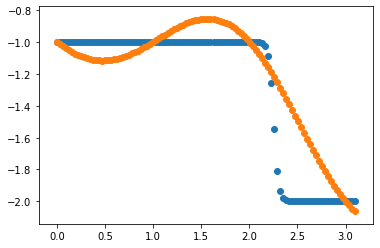

In [29]:
#comparacion tanh con GP
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C


#w_i = [-1,  -0.9,  -1.1,  -1,  -1.1,  -1.2,  -1.4,  -0.9]
#z_i = np.linspace(0.0,3.0,9)

w_i = [-1,  -1., -1., -2.0]
#w_i = [-1,  -1.5]
z_i = np.linspace(0.0,3.0,5)

z=np.linspace(0.0,3.1,100)


def wz_tanh(z):
    def bines(w_2,w_1,z_2,z_1,eta):
        return (w_2-w_1)*(1+np.tanh((z_2-z_1)/eta))/2
    w=w_i[0]
    for jj in range(len(w_i)-1):
        w+=bines(w_i[jj+1],w_i[jj],z,z_i[jj+1],0.05)
    return(w)



def wz_gp(z):
    z_i_gp = np.atleast_2d(np.linspace(0.0,3.0,len(w_i))).T
    kernel = RBF(1,(1e-2,1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10 )#), optimizer = None)
    gp.fit(z_i_gp, w_i)
    ide = gp.predict([[z]])
    return(ide[0])


plt.scatter(z,[wz_tanh(i) for i in z])
plt.scatter(z,[wz_gp(i) for i in z])

#plt.plot(z,wz_tanh(z))
#plt.plot(z,wz_gp(z))

In [47]:
wz_gp(1)

-1.0561159603212218

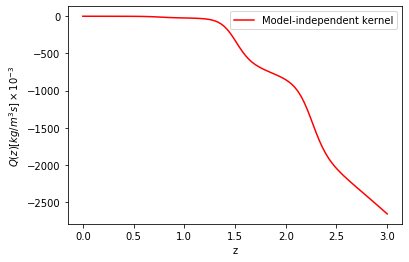

In [13]:
#Q(z) para tanh con eos variable

'''Om: 0.2893 +/- 0.0175
Obh2: 0.0221 +/- 0.0005
h: 0.6614 +/- 0.0196'''
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C
from scipy.constants import G, pi

#w_i = [-1,  -1,  -0.9,  -1.2,  -1,  -1.5,  -1.4,  -1.3]
#z_ide = [0,  0.1,   0.2, 0.4,   0.6,   1.5,   2.0,   3.0]
z=np.linspace(0.0,3,100)

def wz_tanh(z):
    w_i = [ -0.9698, -1.5549,  -1.7246,  -1.7864]
    z_i = np.linspace(0.0,3.0,len(w_i)+1)
    def bines(w_2,w_1,z_2,z_1,eta):
        return (w_2-w_1)*(1+np.tanh((z_2-z_1)/eta))/2
    w=w_i[0]
    for jj in range(len(w_i)-1):
        w+=bines(w_i[jj+1],w_i[jj],z,z_i[jj+1],0.15)
    return(w)

def ide_tanh(z):
    ide_i = [-0.021, -0.1398, -2.5682, -4.8722]
    z_i = np.linspace(0.0,3.0,len(ide_i)+1)
    def bines(w_2,w_1,z_2,z_1,eta):
        return (w_2-w_1)*(1+np.tanh((z_2-z_1)/eta))/2
    ide=ide_i[0]
    for jj in range(len(ide_i)-1):
        ide+=bines(ide_i[jj+1],ide_i[jj],z,z_i[jj+1],0.15)
    return(ide)

   
# function that returns drho/dz
def model_de(rho,z):
    drhodz = (3/(1+z))*((1+wz_tanh(z))*rho+ide_tanh(z))
    return drhodz

def model_dm(rho,z):
    drhodz = (3/(1+z))*(rho-ide_tanh(z))
    return drhodz

# initial condition
y0 = 1. - 0.2893
h = 0.6614
# time points
z = np.linspace(0,3.0,100)

# solve ODE
rho_de = odeint(model_de,y0,z)
rho_dm = odeint(model_dm,1-y0,z)

def h_z(z):
    hubble = []
    for ii in range(len(z)):
        hubble += [100*h*(rho_de[ii]+rho_dm[ii])**0.5]
    return hubble

def Q_z(z):
    int_k = []
    rho_crit = (3*h*h*10000)/(8*pi)
    #rho_crit = 1
    for ii in range(len(z)):
        int_k += [3*rho_crit*ide_tanh(z)[ii]*h_z(z)[ii]/1000] 
    return int_k

# plot results
plt.plot(z,Q_z(z),'r-',label='Model-independent kernel')
plt.ylabel(r'$Q(z) [kg/m^3s]\times 10^{-3}$')
plt.xlabel('z')
plt.legend(loc='best')
plt.savefig('figs_ide/model-independent-kernel.pdf')
plt.show()


No handles with labels found to put in legend.


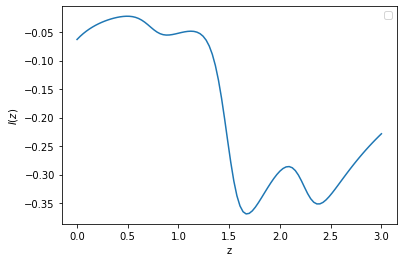

In [14]:
#el adimensional de Nucamendi
plt.ylabel(r'$I(z)$')
plt.xlabel('z')
plt.legend(loc='best')
plt.plot(z,3*ide_tanh(z)/((1+z)**3))
plt.savefig('figs_ide/nucamendi_model_independent.pdf')


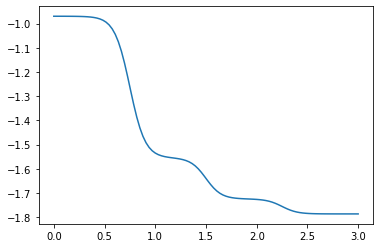

In [15]:
#la ec. de estado
plt.plot(z, wz_tanh(z))

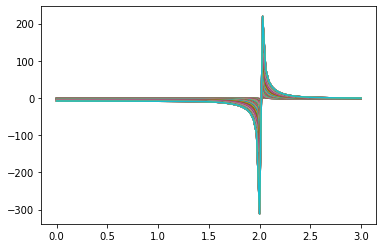

In [24]:
#la w_eff

rho_crit = (3*h*h*10000)/(8*pi)
w_eff = wz_tanh(z) + ide_tanh(z)/rho_de

plt.plot(z,w_eff)


# Con EOS igual a -1

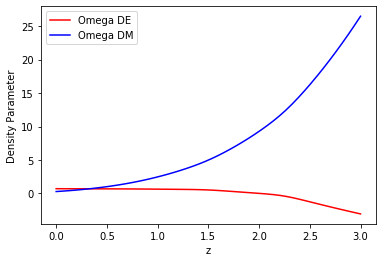

In [6]:
#con tanh
#prueba para ver como varia rho
'''
zbin_eos0: -0.9698 +/- 0.0579
zbin_eos1: -1.5549 +/- 0.7411
zbin_eos2: -1.7246 +/- 1.0318
zbin_eos3: -1.7864 +/- 1.0068
zbin_ide0: -0.0210 +/- 0.0161
zbin_ide1: -0.1398 +/- 0.1223
zbin_ide2: -2.5682 +/- 2.1757
zbin_ide3: -4.8722 +/- 2.8267
'''


import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C


z=np.linspace(0.0,3,100)

def ide_tanh(z):
    ide_i = [-0.0183, -0.0889, -1.0175, -4.5365]
    z_i = np.linspace(0.0,3.0,len(ide_i)+1)
    def bines(w_2,w_1,z_2,z_1,eta):
        return (w_2-w_1)*(1+np.tanh((z_2-z_1)/eta))/2
    ide=ide_i[0]
    for jj in range(len(ide_i)-1):
        ide+=bines(ide_i[jj+1],ide_i[jj],z,z_i[jj+1],0.15)
    return(ide)

   
# function that returns drho/dz
def model_de(rho,z):
    drhodz = (3/(1+z))*(ide_tanh(z))
    return drhodz

def model_dm(rho,z):
    drhodz = (3/(1+z))*(rho-ide_tanh(z))
    return drhodz

# initial condition
y0 = 1. - 0.2886
h = 0.6640

# time points
z = np.linspace(0,3.0,50)

# solve ODE
rho_de = odeint(model_de,y0,z)
rho_dm = odeint(model_dm,1-y0,z)

# plot results
plt.plot(z,rho_de,'r-',label='Omega DE')
plt.plot(z,rho_dm,'b-',label='Omega DM')
plt.ylabel('Density Parameter')
plt.xlabel('z')
plt.legend(loc='best')
plt.savefig('figs_ide/density_parameters_ide_no_eos.pdf')
plt.show()


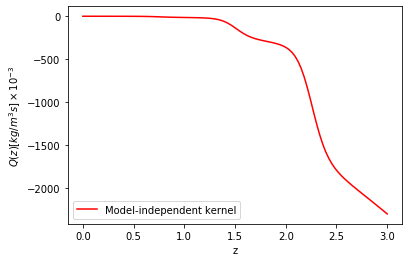

In [5]:
#sin ecuacion de estado variable, solo varia el kernel de interaccion

'''
Om: 0.2893 +/- 0.0175
Obh2: 0.0221 +/- 0.0005
h: 0.6614 +/- 0.0196
'''
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C
from scipy.constants import G, pi


z=np.linspace(0.0,3,100)


def ide_tanh(z):
    ide_i = [-0.0183, -0.0889, -1.0175, -4.5365]
    z_i = np.linspace(0.0,3.0,len(ide_i)+1)
    def bines(w_2,w_1,z_2,z_1,eta):
        return (w_2-w_1)*(1+np.tanh((z_2-z_1)/eta))/2
    ide=ide_i[0]
    for jj in range(len(ide_i)-1):
        ide+=bines(ide_i[jj+1],ide_i[jj],z,z_i[jj+1],0.15)
    return(ide)

   
# function that returns drho/dz
def model_de(rho,z):
    drhodz = (3/(1+z))*(ide_tanh(z))
    return drhodz

def model_dm(rho,z):
    drhodz = (3/(1+z))*(rho-ide_tanh(z))
    return drhodz

# initial condition
y0 = 1. - 0.2886
h = 0.6640
# time points
z = np.linspace(0,3.0,100)

# solve ODE
rho_de = odeint(model_de,y0,z)
rho_dm = odeint(model_dm,1-y0,z)

def h_z(z):
    hubble = []
    for ii in range(len(z)):
        hubble += [100*h*(rho_de[ii]+rho_dm[ii])**0.5]
    return hubble

def Q_z(z):
    int_k = []
    rho_crit = (3*h*h*10000)/(8*pi)
    #rho_crit = 1
    for ii in range(len(z)):
        int_k += [3*rho_crit*ide_tanh(z)[ii]*h_z(z)[ii]/1000] 
    return int_k

# plot results
plt.plot(z,Q_z(z),'r-',label='Model-independent kernel')
plt.ylabel(r'$Q(z) [kg/m^3s]\times 10^{-3}$')
plt.xlabel('z')
plt.legend(loc='best')
plt.savefig('figs_ide/model-independent-kernel_no_eos.pdf')
plt.show()


No handles with labels found to put in legend.


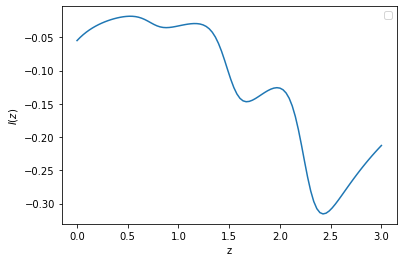

In [27]:
#el adimensional de Nucamendi
plt.ylabel(r'$I(z)$')
plt.xlabel('z')
plt.legend(loc='best')
plt.plot(z,3*ide_tanh(z)/((1+z)**3))
plt.savefig('figs_ide/nucamendi_model_independent_no_eos.pdf')


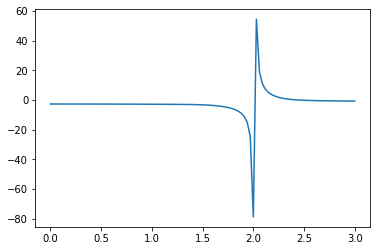

In [32]:
#la w_eff

rho_crit = (3*h*h*10000)/(8*pi)
w_eff = -1 + ide_tanh(2)/rho_de

plt.plot(z,w_eff)

In [ ]:
#Esto es lo que tengo en SimpleMC IDEGPCosmology

    def __init__(self, varyw_ide=True):

        self.Nbins_ide = 10
        mean_ide = -1.0
        self.params_ide = [Parameter("zbin_ide%d"%i, mean_ide, 1.0, (-10.0, 3.0), "zbin_ide%d"%i) for i in range(self.Nbins_ide)]
        self.pvals_ide = [i.value for i in self.params_ide]

        self.varyw_ide = varyw_ide
        self.w_ide = w_ide_par.value


        #self.w_ide_par = Parameter("w_ide", -1.0, 0.1, (-3.0,1.0), "w_{ide}")
        #self.w_ide = self.w_ide_par.value

        self.zinter = np.linspace(0.0, 3.0, 50)

        LCDMCosmology.__init__(self, mnu=0)
        self.updateParams([])

    # my free parameters. We add Ok on top of LCDM ones (we inherit LCDM)
    def freeParameters(self):
        l = LCDMCosmology.freeParameters(self)
        #l.append(self.w_ide_par)
        if (self.varyw_ide): l.append(w_ide_par)
        l+= self.params_ide
        return l

    def updateParams(self, pars):
        ok = LCDMCosmology.updateParams(self, pars)
        if not ok:
            return False
        for p in pars:
            if p.name == ("w_ide"):
                self.w_ide = p.value
            for i in range(self.Nbins_ide):
                if p.name == ("zbin_ide"+str(i)):
                    self.pvals_ide[i] = p.value
        self.initialize()
        return True



    def de_ide(self, z):
        ide_i = np.asarray(self.pvals_ide)
        z_i = np.atleast_2d(np.linspace(0.0,3.0,len(self.params_ide))).T
        kernel = RBF(1,(1e-2,1e2))
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1, optimizer=None)
        #gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=0)
        gp.fit(z_i, ide_i)
        ide = gp.predict([[z]])
        return ide[0]

    def de_rhow(self, rho_de, z):
        drhodedz = (3.0/(1.0+z))*((1.0+self.w_ide)*rho_de+self.de_ide(z))
        return drhodedz

    def dm_rhow(self, rho_dm, z):
        drhodmdz = (3.0/(1.0+z))*(rho_dm-self.de_ide(z))
        return drhodmdz

    def initialize(self):
        rhowde = np.reshape(odeint(self.de_rhow ,1.0-self.Om ,self.zinter),len(self.zinter))
        rhowdm = np.reshape(odeint(self.dm_rhow ,self.Om ,self.zinter),len(self.zinter))
        self.rhowde_inter = interp1d(self.zinter, rhowde)
        self.rhowdm_inter = interp1d(self.zinter, rhowdm)
        return True

    ## this is relative hsquared as a function of a
    ## i.e. H(z)^2/H(z=0)^2
    def RHSquared_a(self,a):
        z= 1./a - 1
        if z>= 3.0:
            om_de = (1.0-self.Om)
            om_dm = (self.Om)
        else:
            om_de = self.rhowde_inter(z)
            om_dm = self.rhowdm_inter(z)
        if om_dm+self.Omrad/a**4 + om_de > 0 :
            return om_dm + self.Omrad/a**4 + om_de
        elif om_dm + self.Omrad/a**4 + om_de <=0 :
            return 0.5




In [ ]:
  def __init__(self):

        self.Nbins_ide = 5
        mean_ide = 0.0
        self.params_ide = [Parameter("zbin_ide%d"%i, mean_ide, 1.0, (-10.0, 3.0), "zbin_ide%d"%i) for i in range(self.Nbins_ide)]
        self.pvals_ide = [i.value for i in self.params_ide]



        self.Nbins_eos = 5
        mean_eos = -1.0
        self.params_eos = [Parameter("zbin_eos%d"%i, mean_eos, 1.0, (-4.0, 1.), "zbin_eos%d"%i) for i in range(self.Nbins_eos)]
        self.pvals_eos = [i.value for i in self.params_eos]


        self.zinter = np.linspace(0.0, 3.0, 50)

        LCDMCosmology.__init__(self, mnu=0)
        self.updateParams([])


    # my free parameters. We add Ok on top of LCDM ones (we inherit LCDM)
    def freeParameters(self):
        l = LCDMCosmology.freeParameters(self)
        l+= self.params_eos
        l+= self.params_ide
        return l

    def updateParams(self, pars):
        ok = LCDMCosmology.updateParams(self, pars)
        if not ok:
            return False
        for p in pars:
            for j in range(self.Nbins_eos):
                if p.name == ("zbin_eos"+str(j)):
                    self.pvals_eos[j] = p.value
            for i in range(self.Nbins_ide):
                if p.name == ("zbin_ide"+str(i)):
                    self.pvals_ide[i] = p.value
        self.initialize()
        return True


    def de_ide(self, z):
        ide_i = np.asarray(self.pvals_ide)
        z_i = np.atleast_2d(np.linspace(0.0,3.0,len(self.params_ide))).T
        kernel = RBF(1,(1e-2,1e2))
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1, optimizer=None)
        gp.fit(z_i, ide_i)
        ide = gp.predict([[z]])
        return ide[0]

    def de_eos(self, z):
        w_i = np.asarray(self.pvals_eos)
        z_i = np.atleast_2d(np.linspace(0.0,3.0,len(self.params_eos))).T
        kernel = RBF(1,(1e-2,1e2))
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1, optimizer=None)
        gp.fit(z_i, w_i)
        w = gp.predict([[z]])
        return w[0]


    def de_rhow(self, rho_de, z):
        drhodedz = (3.0/(1.0+z))*((1.0+self.de_eos(z))*rho_de+self.de_ide(z))
        return drhodedz

    def dm_rhow(self, rho_dm, z):
        drhodmdz = (3.0/(1.0+z))*(rho_dm-self.de_ide(z))
        return drhodmdz

    def initialize(self):
        rhowde = np.reshape(odeint(self.de_rhow ,1.0-self.Om ,self.zinter),len(self.zinter))
        rhowdm = np.reshape(odeint(self.dm_rhow ,self.Om ,self.zinter),len(self.zinter))
        self.rhowde_inter = interp1d(self.zinter, rhowde)
        self.rhowdm_inter = interp1d(self.zinter, rhowdm)
        return True


    ## this is relative hsquared as a function of a
    ## i.e. H(z)^2/H(z=0)^2
    def RHSquared_a(self,a):
        z= 1./a - 1
        if z>= 3.0:
            om_de = (1.0-self.Om)
            om_dm = (self.Om)
        else:
            om_de = self.rhowde_inter(z)
            om_dm = self.rhowdm_inter(z)
        #return om_dm + self.Omrad/a**4 + om_de
        if om_dm+self.Omrad/a**4 + om_de > 0 :
            return om_dm + self.Omrad/a**4 + om_de
        elif om_dm + self.Omrad/a**4 + om_de <=0 :
            return 0.5

# Con 10 nodos, GPs y w_ide

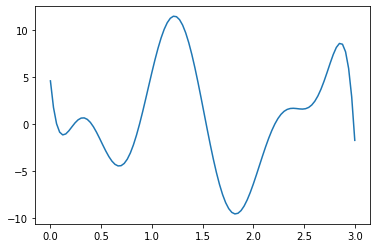

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.misc import derivative
from scipy.interpolate import interp1d
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C


ide_i = [4.57010208, 0.63395794, -4.46403402, 5.45757061, 9.68690119, -6.44964938, -6.38060264, 1.530751, 3.68288257, -1.75079595]
#ide_i = [8.67914971, -0.44807358, -3.1537372, 3.42390959, 3.80963119, -7.27820735, 0.022819, 3.37411277, -2.70900924, 0.04071768]
z_i = np.atleast_2d(np.linspace(0.0,3.0,len(ide_i))).T
kernel = RBF(1,(1e-2,1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=1, optimizer=None)
gp.fit(z_i, ide_i)
    
x = np.atleast_2d(np.linspace(0, 3, 100)).T
ide_gp = gp.predict(x)
    
def de_ide(z):
    ide = gp.predict([[z]])
    return ide
def model_de(rhode,r):
    drhodz = (3/(1+r))*(rhode*(1-0.45855765)+de_ide(r))
    return drhodz
def model_dm(rhodm,r):
    drhodz = (3/(1+r))*(rhodm-de_ide(r))
    return drhodz

y0 = 0.29301817
zinter = np.linspace(0.0, 3.0, 50)
rhowde = np.reshape(odeint(model_de ,1.0-y0 ,zinter),len(zinter))
rhowdm = np.reshape(odeint(model_dm ,y0 ,zinter),len(zinter))
rho_de = interp1d(zinter, rhowde, kind='cubic')
rho_dm = interp1d(zinter, rhowdm, kind='cubic')


def Hz(r):
    return 0.68113847*100*(rho_dm(r) + rho_de(r))**0.5
    #return (rho_dm(r) + rho_de(r))**0.5
def Qz(r):
    #multiplicar por ide_gp
    return -((9*0.68113847*0.68113847)/(8*np.pi))*Hz(r)
def deltaz(r):
    #multiplicarlo por ide_gp en return
    return -((27)/(8*np.pi*0.68113847*100))*Hz(r)/((1+r)**4)
def qz(r):
    dhz = [derivative(Hz, ii, dx=1e-6) for ii in r]
    return (1+r)*dhz/Hz(r) - 1 
def w_eff(r):
    #multiplicar por ide_gp y sumar theta[12]
    e_o_s = -1/(rho_de(r))
    for n,i in enumerate(e_o_s):
        if i>16:
            e_o_s[n] = 16
        elif i<-16:
            e_o_s[n] = -16
    return e_o_s


z = np.linspace(0.00001,2.9999,100)
plt.plot(z,ide_gp)